### In order to produce models with better accuracy, I'm going to make an analysis of the variables and how much they affect to the response variable. 

In [1]:
# Data processing
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Datetime management
# -----------------------------------------------------------------------
import datetime as dt

# Plots
# ------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,10) 

In [2]:
# Loading a dataframe with the data provided
df = pd.read_csv('data/train.csv')
df.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
0,33446280,14:11:09,AR,55379,PAID,2,11.88,DeliveredStatus
1,33107339,11:47:41,GT,23487,PAID,2,5.20,DeliveredStatus
2,32960645,11:53:53,CR,62229,PAID,1,6.03,DeliveredStatus
3,32089564,20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
4,32157739,21:32:16,AR,13917,PAID,1,5.36,CanceledStatus


### local_time vs final_status
Let's see how much the time the order was placed influences the final status.

In [3]:
# Transforming the local time to hour granularity for better comprehension
df['local_time'] = df['local_time'].astype('datetime64').dt.hour
df.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
0,33446280,14,AR,55379,PAID,2,11.88,DeliveredStatus
1,33107339,11,GT,23487,PAID,2,5.20,DeliveredStatus
2,32960645,11,CR,62229,PAID,1,6.03,DeliveredStatus
3,32089564,20,ES,29446,PAID,6,6.37,DeliveredStatus
4,32157739,21,AR,13917,PAID,1,5.36,CanceledStatus


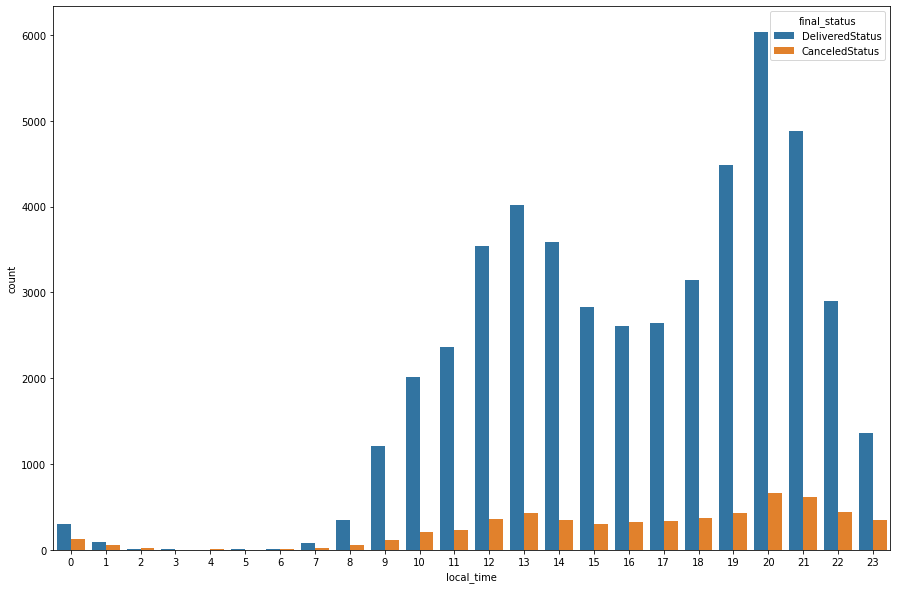

In [4]:
# Plotting the amount of orders per hour and their final status
sns.countplot(x='local_time', data=df, hue='final_status');
plt.show()

> Here we see that there are times where the ratio of canceled statuses rises.

/home/chloeiris/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/chloeiris/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


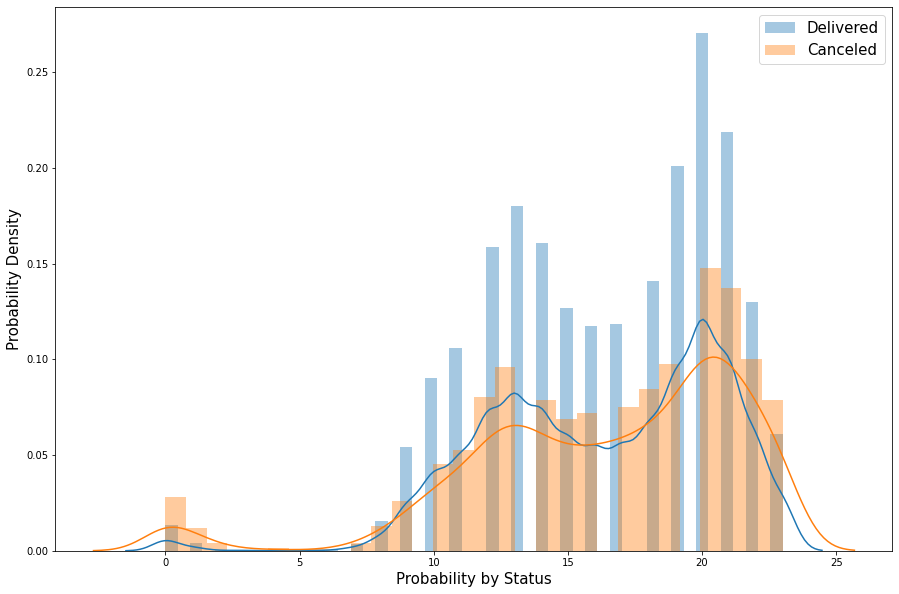

In [16]:
# Plotting the distribution of probability for each status depending on the hour of the day
ax1=sns.distplot(df[df['final_status']=='DeliveredStatus']['local_time'], label='Delivered')
ax2=sns.distplot(df[df['final_status']=='CanceledStatus']['local_time'], label='Canceled')
plt.xlabel('Probability by Status', fontsize=15)
plt.ylabel('Probability Density', fontsize=15)
plt.legend(fontsize=15)
plt.show()

> We can see the probability of ending with a canceled order is higher at some hours of the day.
>
> Therefore, we can conclude that this column is relevant for our model.

##### Creating a dataframe where we can see the actual ratios of delivery per hour

In [20]:
# Here is the total count of orders per hour
group_count= df.groupby('local_time').count().reset_index()
group_count.head()

,local_time,order_id,country_code,store_address,payment_status,n_of_products,products_total,final_status
0,0,430,430,430,430,430,430,430
1,1,147,147,147,147,147,147,147
2,2,27,27,27,27,27,27,27
3,3,14,14,14,14,14,14,14
4,4,6,6,6,6,6,6,6


In [21]:
# Let's create a column with a binary encoding of the final status so we can add up the 1s and make a ratio of deliveries
df['final_status_binary']=pd.get_dummies(df['final_status'], drop_first=True)
df.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status,final_status_binary
0,33446280,14,AR,55379,PAID,2,11.88,DeliveredStatus,1
1,33107339,11,GT,23487,PAID,2,5.20,DeliveredStatus,1
2,32960645,11,CR,62229,PAID,1,6.03,DeliveredStatus,1
3,32089564,20,ES,29446,PAID,6,6.37,DeliveredStatus,1
4,32157739,21,AR,13917,PAID,1,5.36,CanceledStatus,0


In [22]:
# Here is the sum of the delivered orders
group_delivered = df.groupby('local_time').sum().reset_index()
group_delivered.head()

,local_time,order_id,store_address,n_of_products,products_total,final_status_binary
0,0,14071178018,20199018,772,2189.69,305.0
1,1,4807774915,7340396,280,773.55,93.0
2,2,878022017,1354055,50,193.63,9.0
3,3,456136322,802597,22,100.23,11.0
4,4,197572130,370964,10,34.46,0.0


In [23]:
# Empty dataframe to append new calculated columns
ratios = pd.DataFrame()

In [24]:
ratios['hour'] = group_count['local_time']
ratios['total_orders'] = group_count['order_id']
ratios['delivered'] = group_delivered['final_status_binary']
ratios['delivered_ratios'] = ratios['delivered'] / ratios['total_orders']
ratios.head()

,hour,total_orders,delivered,delivered_ratios
0,0,430,305.0,0.709302
1,1,147,93.0,0.632653
2,2,27,9.0,0.333333
3,3,14,11.0,0.785714
4,4,6,0.0,0.000000


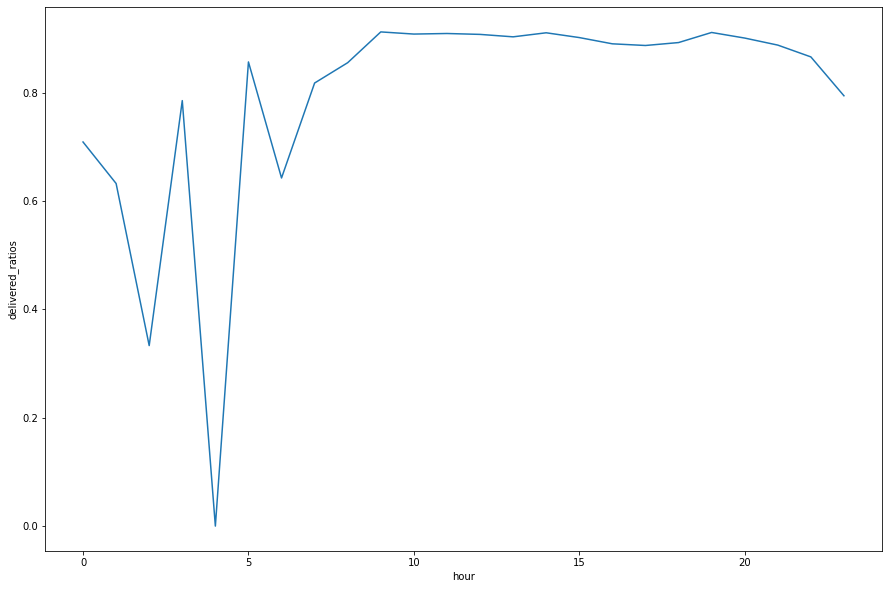

In [28]:
sns.lineplot(x='hour', y='delivered_ratios', data=ratios);

> The DeliveredStatus ratio is stable throughout the day, and starts descending at night

### country_code vs final_status

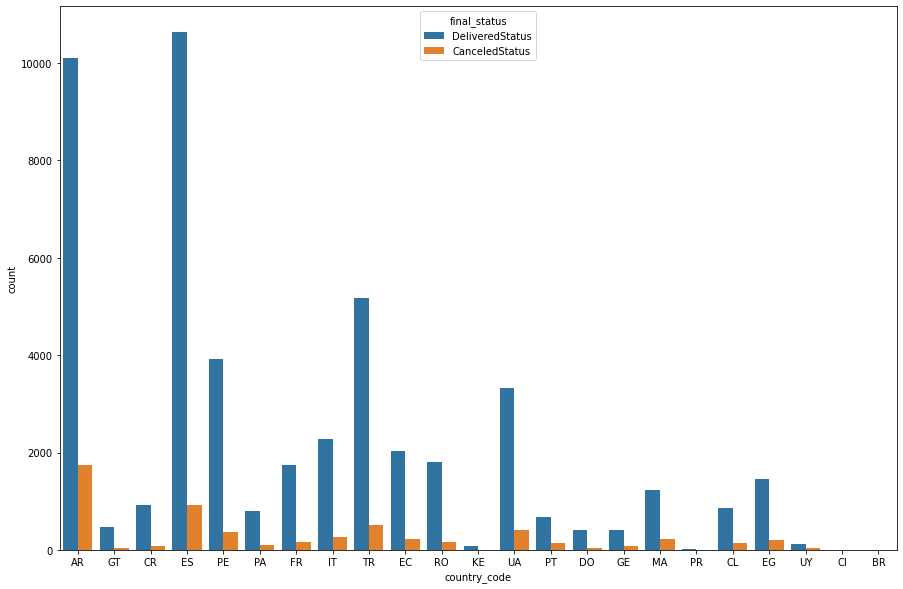

In [30]:
sns.countplot(x='country_code', data = df, hue= 'final_status');

In [31]:
group_country = df.groupby(['country_code']).count().reset_index()
group_country.head()

,country_code,order_id,local_time,store_address,payment_status,n_of_products,products_total,final_status,final_status_binary
0,AR,11854,11854,11854,11854,11854,11854,11854,11854
1,BR,1,1,1,1,1,1,1,1
2,CI,6,6,6,6,6,6,6,6
3,CL,994,994,994,994,994,994,994,994
4,CR,1000,1000,1000,1000,1000,1000,1000,1000


In [32]:
group_country_sum = df.groupby(['country_code']).sum().reset_index()
group_country_sum.head()

,country_code,order_id,local_time,store_address,n_of_products,products_total,final_status_binary
0,AR,389010903865,206543,578535813,26743,77390.82,10107.0
1,BR,31848304,7,49346,8,6.01,0.0
2,CI,197735331,101,449074,6,0.22,3.0
3,CL,32622993742,16995,29172595,1989,135.11,857.0
4,CR,32786599811,15713,52441197,1674,10098.87,926.0


In [34]:
ratios_country = pd.DataFrame()
ratios_country['country'] = group_country['country_code']
ratios_country['total_orders'] = group_country['order_id']
ratios_country['delivered'] = group_country_sum['final_status_binary']
ratios_country['delivered_ratios'] = ratios_country['delivered'] / ratios_country['total_orders']
ratios_country.head()

,country,total_orders,delivered,delivered_ratios
0,AR,11854,10107.0,0.852624
1,BR,1,0.0,0.000000
2,CI,6,3.0,0.500000
3,CL,994,857.0,0.862173
4,CR,1000,926.0,0.926000


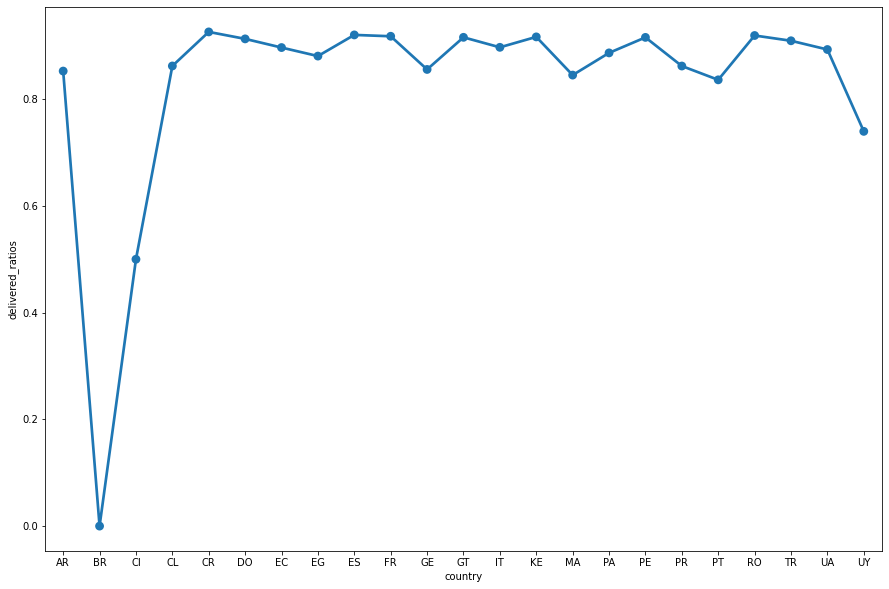

In [37]:
sns.pointplot(x='country', y= 'delivered_ratios', data=ratios_country);

> There is some variabilty between countries, so this could affect our model.
>
> In the case of Brazil the only order that was placed was also canceled. 
>
> Ivory Coast also shows few orders and half of them were canceled.
>
> This can make us think that the number of orders placed, which means popularity in each country, affects the cancelation ratio.
>
> For these reasons I believe this column is important to include in the prediction model.


### n_of_products vs final_status